In [3]:
import numpy as np
import sdf
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext line_profiler

FONTSIZE = 8
COLUMN_WIDTH = 468.0 * 1/72.27
COLUMN_HALFSIZE = 0.5 # Multiplier
COLUMN_THIRDSIZE = 0.32

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
def latexify(fig_width=None, fig_height=None, columns=1, square=False):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}, optional
    square: boolean,optional
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2,3])

    if fig_width is None:
        if columns == 1:
            fig_width = COLUMN_WIDTH
        elif columns == 2:
            fig_width = COLUMN_WIDTH * COLUMN_HALFSIZE  
        else:
            fig_width = COLUMN_WIDTH * COLUMN_THIRDSIZE

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
        
    if square:
        fig_height = fig_width
        
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': FONTSIZE, # fontsize for x and y labels (was 10)
              'axes.titlesize': FONTSIZE,
              'font.size': FONTSIZE, # was 10
              'legend.fontsize': FONTSIZE, # was 10
              'xtick.labelsize': FONTSIZE,
              'ytick.labelsize': FONTSIZE,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

def get_var_slice(sdfFilename, variable):
    sdfFile = sdf.read(sdfFilename)

    sdf_var = getattr(sdfFile, variable)
    var = sdf_var.data
    dims = sdf_var.dims

    # If z-dimensions even, average between midpoints
    average = (dims[2] % 2 == 0)

    if average:
        return 0.5*(var[:,:,int(dims[2]/2)-1] + var[:,:,int(dims[2]/2)]).transpose()
    else:
        return var[:,:,int(dims[2]/2)].transpose()

def get_dx_dy_dz(sdfFile):
    extents = sdfFile.Grid_Grid.extents
    dims = sdfFile.Grid_Grid.dims
    
    dims = [dim + 1 for dim in dims]
    
    return [(extents[i+3] - extents[i])/dims[i] for i in range(3)]

def get_magnetic_field(sdfFilename):
    sdfFile = sdf.read(sdfFilename)
    
    mag_field = np.array([
        getattr(sdfFile, variable).data for variable in 
        ['Magnetic_Field_bx_centred', 'Magnetic_Field_by_centred', 'Magnetic_Field_bz_centred']
    ])

    return mag_field

def get_variable(sdfFile, varname):
    return getattr(sdfFile, varname)
    
def slice_variable(sdf_var, x_min=0, x_max=-1, y_min=0, y_max=-1, z_min=0, z_max=-1):
    if(x_max < 0):
        x_max = sdf_var.dims[0]
    if(y_max < 0):
        y_max = sdf_var.dims[1]
    if(z_max < 0):
        z_max = sdf_var.dims[2]
    
    return sdf_var.data[x_min:x_max, y_min:y_max, z_min:z_max]

def curl(bx, by, bz, dx, dy, dz):
    gradbx = np.gradient(bx, dx, dy, dz)
    gradby = np.gradient(by, dx, dy, dz)
    gradbz = np.gradient(bz, dx, dy, dz)
    
    return np.array([(gradbz[1] - gradby[2]), -(gradbz[0] - gradbx[2]), (gradby[0] - gradbx[1])])

def get_magnitude_current_at(sdfFile, zSliceIdx, xLimits = (0,-1), yLimits=(0,-1)):
    bx = slice_variable(\
        get_variable(sdfFile, "Magnetic_Field_bx_centred"),\
        x_min=xLimits[0], x_max = xLimits[1],\
        y_min=yLimits[0], y_max = yLimits[1],\
        z_min=zSliceIdx - 1, z_max = zSliceIdx + 2)
    by = slice_variable(\
        get_variable(sdfFile, "Magnetic_Field_by_centred"),\
        x_min=xLimits[0], x_max = xLimits[1],\
        y_min=yLimits[0], y_max = yLimits[1],\
        z_min=zSliceIdx - 1, z_max = zSliceIdx + 2)
    bz = slice_variable(\
        get_variable(sdfFile, "Magnetic_Field_bz_centred"),\
        x_min=xLimits[0], x_max = xLimits[1],\
        y_min=yLimits[0], y_max = yLimits[1],\
        z_min=zSliceIdx - 1, z_max = zSliceIdx + 2)
    
    dx, dy, dz = get_dx_dy_dz(sdfFile)

    gradbx = np.gradient(bx, dx, dy, dz)
    gradby = np.gradient(by, dx, dy, dz)
    gradbz = np.gradient(bz, dx, dy, dz)

    current_density = np.sqrt(np.power(gradbz[1] - gradby[2], 2) + np.power(gradbz[0] - gradbx[2], 2) + np.power(gradby[0] - gradbx[1], 2))
    current_density = current_density[:,::-1,int(current_density.shape[2]/2)]
    return current_density.transpose()

def get_temperature_at(sdfFile, zSliceIdx, xLimits = (0,-1), yLimits=(0,-1)):
    # Temperature in nondim units is just \gamma - 1 times the internal energy
    gamma = 5.0/3
    temp = (gamma-1) * slice_variable(\
        get_variable(sdfFile, "Fluid_Energy"),\
        x_min=xLimits[0], x_max = xLimits[1],\
        y_min=yLimits[0], y_max = yLimits[1],\
        z_min=zSliceIdx, z_max = zSliceIdx+1)
    
    temp = temp[:,:].squeeze(axis=2).transpose()
    
    return temp

def length_to_index(length):
    # This is hardcoded - could be made better by including limits from the actual sdf file
    return int((length + 2)*350/4)

def dimensionalise_temperature(tempIn):
    B0 = 5
    mf = 1.2
    mh_si = 1.672621777
    kb_si = 1.3806488
    mu0_si = 4.0 * np.pi
    RHO0 = 1.67
    T0 = (B0*B0)*mf*mh_si/(kb_si*mu0_si*RHO0) * 1e9

    return T0*tempIn

def plot_current_density_and_velocity(sdfFile, outname, xLimits=(-2, 2), yLimits=(-2, 2),\
                                      max_current=-1, max_temperature=-1, print_maxes=True,\
                                     remove_axes=False):
    latexify(columns=2, square=True)
    fig,axis = plt.subplots()

    if not remove_axes:
        # Make room for labels
        fig.subplots_adjust(left=.12, bottom=0.05, right=.965, top=.99)
    else:
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

    xIndexLimits = tuple((length_to_index(length) for length in xLimits))
    yIndexLimits = tuple((length_to_index(length) for length in yLimits))
    
    current_density = get_magnitude_current_at(sdfFile, 350, xLimits=xIndexLimits, yLimits=yIndexLimits)

    if max_current < 0:
        max_current = int(current_density.max())
    
    axis.imshow(current_density,\
                extent=[xLimits[0], xLimits[1], yLimits[0], yLimits[1]],\
                vmax=max_current, vmin=0,\
                interpolation='bilinear',\
                cmap=plt.get_cmap("Blues"))
    if print_maxes:
        axis.text(-1, 0.9, "Max Current: " + str(max_current), color='w')
    
    print("Max current:", max_current)
    
    temperature = get_temperature_at(sdfFile, 350, xLimits=xIndexLimits, yLimits=yIndexLimits)
    print(dimensionalise_temperature(temperature[0,0]))
    if max_temperature < 0:
        max_temperature = int(dimensionalise_temperature(temperature.max()))
    
    axis.imshow(dimensionalise_temperature(temperature),\
                extent=[xLimits[0], xLimits[1], -yLimits[1], yLimits[0]],\
                vmax=max_temperature, vmin=2e4,\
                interpolation='bilinear',\
                cmap=plt.get_cmap("Reds"))
    
    if print_maxes:
        axis.text(-1, -0.95, "Max temp: " + str(int(max_temperature/1e6)), color='w')
    
    print(r"Max temperature $\times 10^{-6}$:", max_temperature/1e6)
            
    vx = slice_variable(\
        get_variable(sdfFile, "Velocity_Vx"),\
        z_min=350, z_max = 350 + 1)
    vy = slice_variable(\
        get_variable(sdfFile, "Velocity_Vy"),\
        z_min=350, z_max = 350 + 1)
    
    vx = 0.25*(vx[1:,1:] + vx[:-1,1:] + vx[:-1,:-1] + vx[1:,:-1])
    vy = 0.25*(vy[1:,1:] + vy[:-1,1:] + vy[:-1,:-1] + vy[1:,:-1])
    
    vectorIdx = 6
    
    vx = vx.squeeze(axis=2)[\
                            length_to_index(xLimits[0])+int(vectorIdx/2):length_to_index(xLimits[1]):vectorIdx,\
                            length_to_index(yLimits[1])-int(vectorIdx/2):length_to_index(yLimits[0]):-vectorIdx\
                           ].transpose()
    vy = -vy.squeeze(axis=2)[\
                            length_to_index(xLimits[0])+int(vectorIdx/2):length_to_index(xLimits[1]):vectorIdx,\
                            length_to_index(yLimits[1])-int(vectorIdx/2):length_to_index(yLimits[0]):-vectorIdx\
                           ].transpose()
    
    X, Y = np.meshgrid(\
                      np.linspace(xLimits[0], xLimits[1], vx.shape[1]),\
                      np.linspace(-yLimits[1], yLimits[0], vx.shape[0])\
                      )
    
    if remove_axes:
        axis.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    
#     axis.streamplot(X, Y, vx, vy)
    axis.quiver(X, Y, vx, vy, units='xy', pivot='tail', width=0.007, color='k')
    
    plt.savefig(outname, pad_inches=0.0)
    plt.show()
    plt.close(fig)

# Plot current density slices

Max current: 3
309553.53854
Max temperature $\times 10^{-6}$: 84.442284


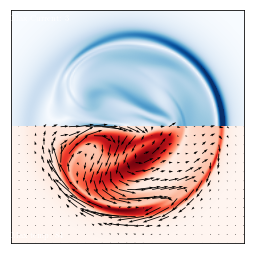

In [72]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"

i=15
timedump = '{0:04d}'.format(i)
sdfFilename = folder + timedump + ".sdf"
sdfFile = sdf.read(sdfFilename)
outname = 'isotropic_current_density_' + timedump + '.pdf'
plot_current_density_and_velocity(sdfFile, outname,\
                xLimits=(-1.0, 1.0),yLimits=(0,1.0),\
                                 remove_axes=True)

0000
Max current: 3
Max temperature $\times 10^{-6}$: 0


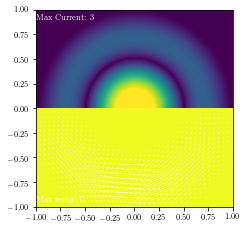

0001
Max current: 3
Max temperature $\times 10^{-6}$: 11


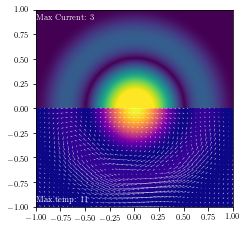

0002
Max current: 3
Max temperature $\times 10^{-6}$: 22


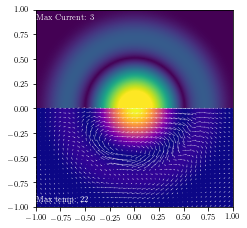

0003
Max current: 3
Max temperature $\times 10^{-6}$: 33


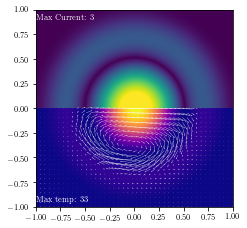

0004
Max current: 3
Max temperature $\times 10^{-6}$: 43


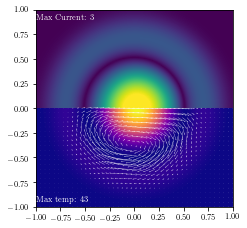

0005
Max current: 3
Max temperature $\times 10^{-6}$: 52


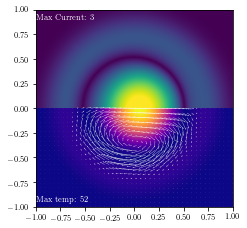

0006
Max current: 3
Max temperature $\times 10^{-6}$: 61


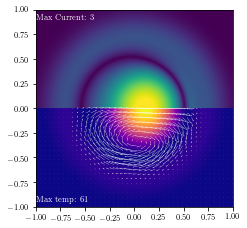

0007
Max current: 2
Max temperature $\times 10^{-6}$: 67


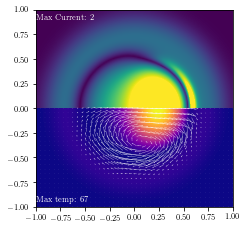

0008
Max current: 7
Max temperature $\times 10^{-6}$: 69


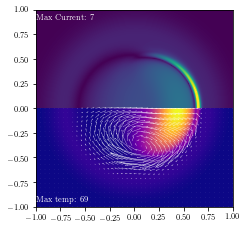

0009
Max current: 10
Max temperature $\times 10^{-6}$: 92


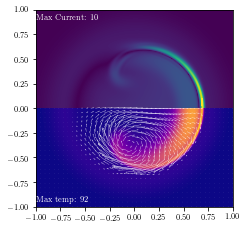

0010
Max current: 8
Max temperature $\times 10^{-6}$: 131


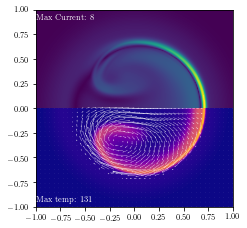

0011
Max current: 5
Max temperature $\times 10^{-6}$: 146


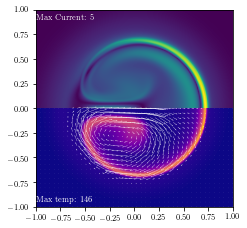

0012
Max current: 4
Max temperature $\times 10^{-6}$: 130


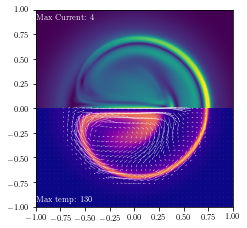

0013
Max current: 4
Max temperature $\times 10^{-6}$: 107


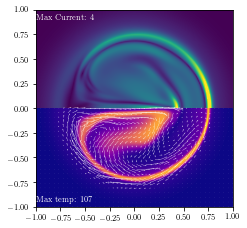

0014
Max current: 4
Max temperature $\times 10^{-6}$: 93


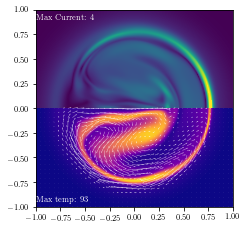

0015
Max current: 3
Max temperature $\times 10^{-6}$: 84


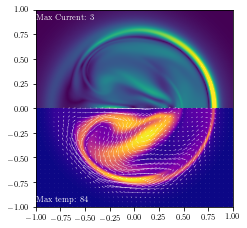

0016
Max current: 3
Max temperature $\times 10^{-6}$: 81


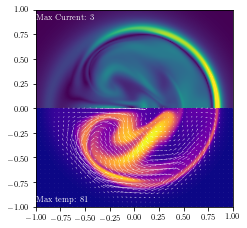

0017
Max current: 3
Max temperature $\times 10^{-6}$: 80


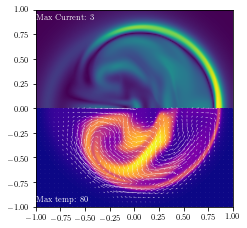

0018
Max current: 3
Max temperature $\times 10^{-6}$: 79


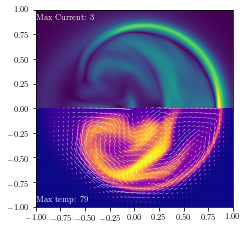

0019
Max current: 2
Max temperature $\times 10^{-6}$: 79


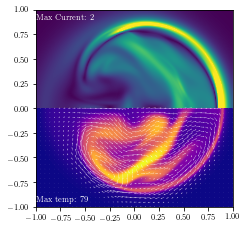

0020
Max current: 2
Max temperature $\times 10^{-6}$: 80


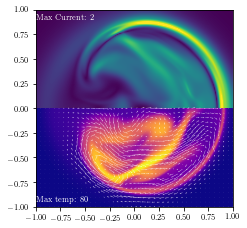

0021
Max current: 2
Max temperature $\times 10^{-6}$: 82


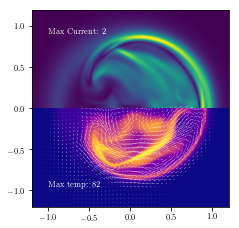

0022
Max current: 2
Max temperature $\times 10^{-6}$: 81


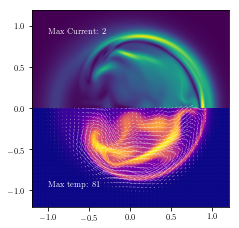

0023
Max current: 2
Max temperature $\times 10^{-6}$: 81


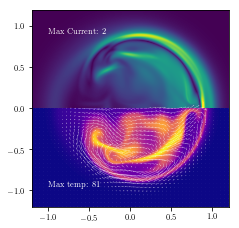

0024
Max current: 2
Max temperature $\times 10^{-6}$: 82


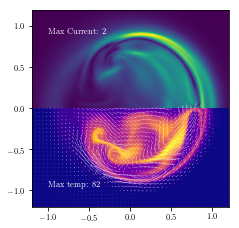

0025
Max current: 2
Max temperature $\times 10^{-6}$: 82


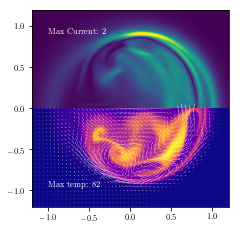

0026
Max current: 2
Max temperature $\times 10^{-6}$: 82


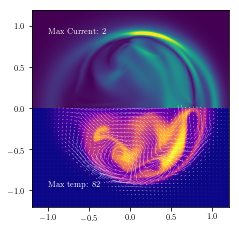

0027
Max current: 2
Max temperature $\times 10^{-6}$: 83


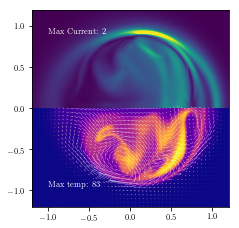

0028
Max current: 2
Max temperature $\times 10^{-6}$: 83


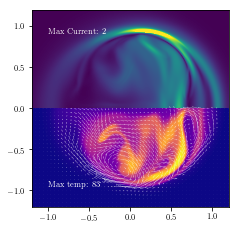

0029
Max current: 3
Max temperature $\times 10^{-6}$: 85


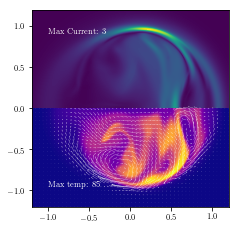

0030
Max current: 3
Max temperature $\times 10^{-6}$: 91


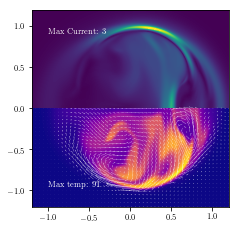

0031
Max current: 3
Max temperature $\times 10^{-6}$: 93


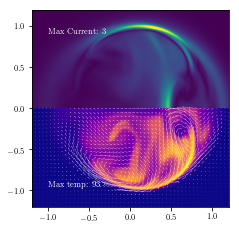

0032
Max current: 3
Max temperature $\times 10^{-6}$: 91


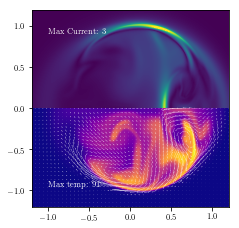

0033
Max current: 3
Max temperature $\times 10^{-6}$: 87


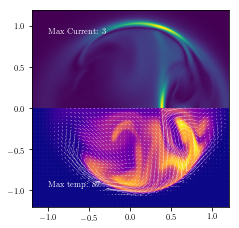

0034
Max current: 3
Max temperature $\times 10^{-6}$: 85


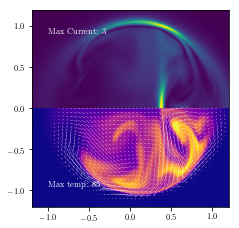

0035
Max current: 3
Max temperature $\times 10^{-6}$: 85


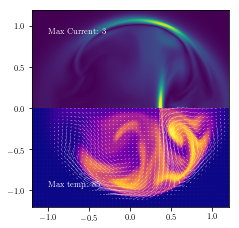

0036
Max current: 3
Max temperature $\times 10^{-6}$: 84


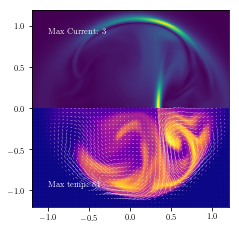

0037
Max current: 3
Max temperature $\times 10^{-6}$: 82


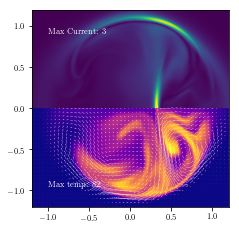

0038
Max current: 3
Max temperature $\times 10^{-6}$: 79


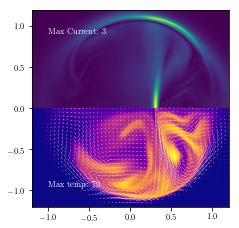

0039
Max current: 3
Max temperature $\times 10^{-6}$: 77


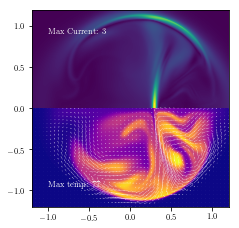

0040
Max current: 3
Max temperature $\times 10^{-6}$: 76


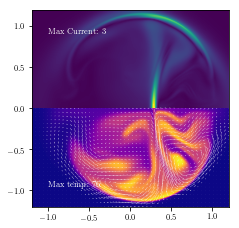

0041
Max current: 2
Max temperature $\times 10^{-6}$: 77


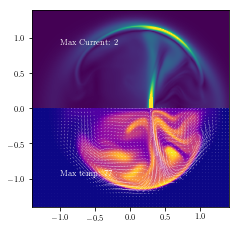

0042
Max current: 2
Max temperature $\times 10^{-6}$: 76


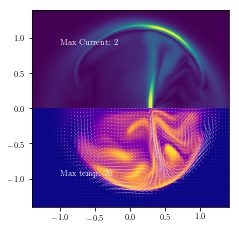

0043
Max current: 2
Max temperature $\times 10^{-6}$: 75


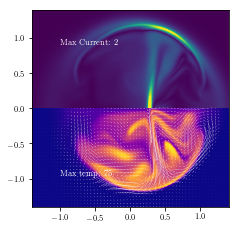

0044
Max current: 2
Max temperature $\times 10^{-6}$: 72


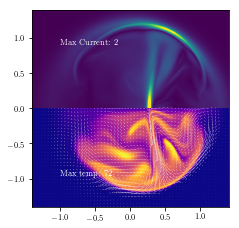

0045
Max current: 2
Max temperature $\times 10^{-6}$: 73


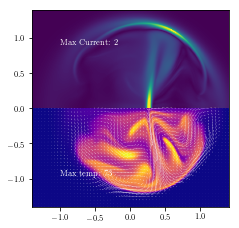

0046
Max current: 2
Max temperature $\times 10^{-6}$: 74


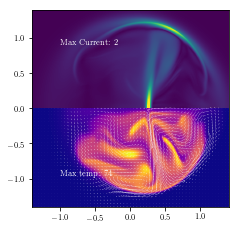

0047
Max current: 2
Max temperature $\times 10^{-6}$: 74


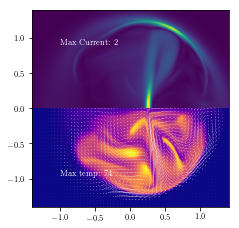

0048
Max current: 2
Max temperature $\times 10^{-6}$: 75


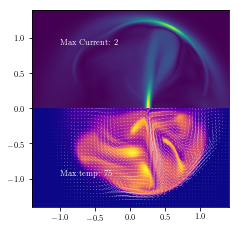

0049
Max current: 1
Max temperature $\times 10^{-6}$: 76


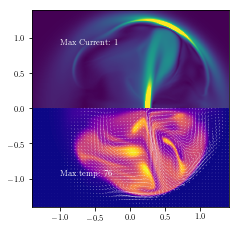

0050
Max current: 1
Max temperature $\times 10^{-6}$: 77


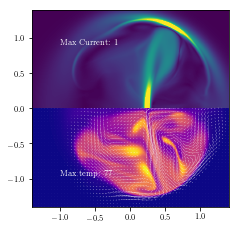

0051
Max current: 1
Max temperature $\times 10^{-6}$: 77


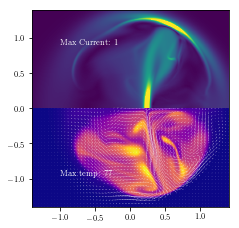

0052
Max current: 1
Max temperature $\times 10^{-6}$: 78


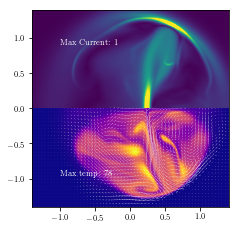

0053
Max current: 1
Max temperature $\times 10^{-6}$: 79


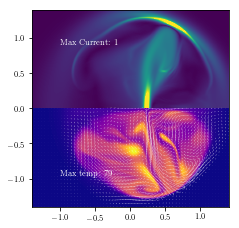

0054
Max current: 1
Max temperature $\times 10^{-6}$: 79


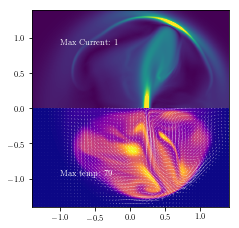

0055
Max current: 1
Max temperature $\times 10^{-6}$: 79


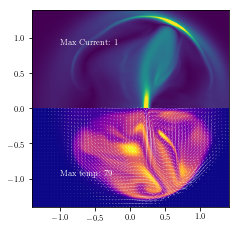

In [10]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"

xLimits = [(-1, 1) for i in range(21)]\
+ [(-1.2, 1.2) for i in range(21, 41)]\
+ [(-1.4, 1.4) for i in range(41, 56)]
yLimits = [(0, 1) for i in range(21)]\
+ [(0, 1.2) for i in range(21, 41)]\
+ [(0, 1.4) for i in range(41, 56)]

for i in range(0, 56):
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'isotropic_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                    xLimits=xLimits[i],yLimits=yLimits[i])
     

0000
Max current: 3
Max temperature $\times 10^{-6}$: 0


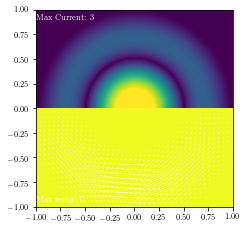

0001
Max current: 3
Max temperature $\times 10^{-6}$: 11


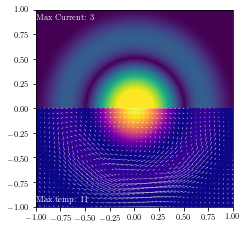

0002
Max current: 3
Max temperature $\times 10^{-6}$: 22


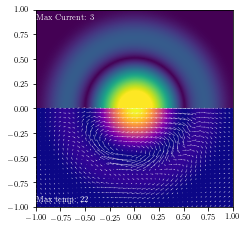

0003
Max current: 3
Max temperature $\times 10^{-6}$: 33


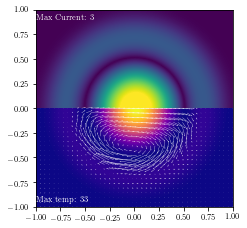

0004
Max current: 3
Max temperature $\times 10^{-6}$: 43


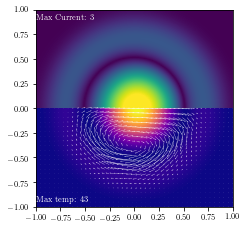

0005
Max current: 3
Max temperature $\times 10^{-6}$: 52


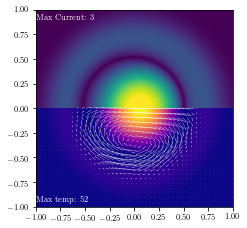

0006
Max current: 3
Max temperature $\times 10^{-6}$: 61


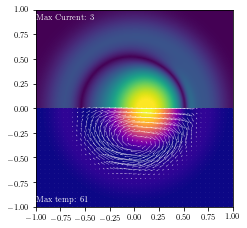

0007
Max current: 3
Max temperature $\times 10^{-6}$: 67


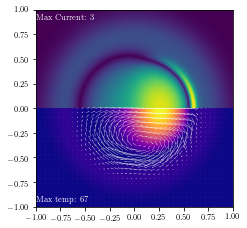

0008
Max current: 8
Max temperature $\times 10^{-6}$: 68


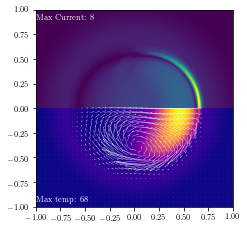

0009
Max current: 10
Max temperature $\times 10^{-6}$: 90


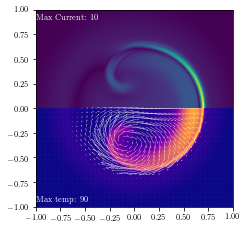

0010
Max current: 7
Max temperature $\times 10^{-6}$: 113


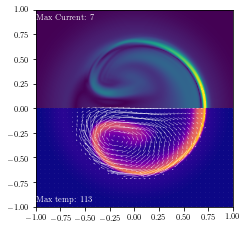

0011
Max current: 4
Max temperature $\times 10^{-6}$: 119


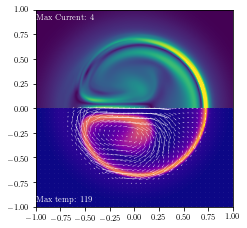

0012
Max current: 4
Max temperature $\times 10^{-6}$: 101


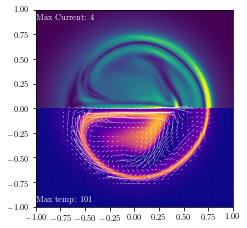

0013
Max current: 7
Max temperature $\times 10^{-6}$: 81


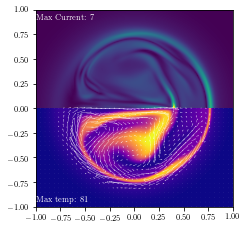

0014
Max current: 3
Max temperature $\times 10^{-6}$: 79


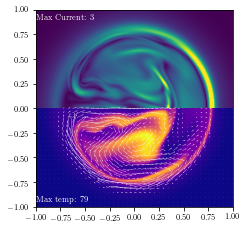

0015
Max current: 3
Max temperature $\times 10^{-6}$: 78


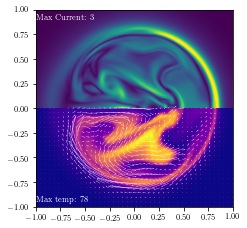

0016
Max current: 3
Max temperature $\times 10^{-6}$: 76


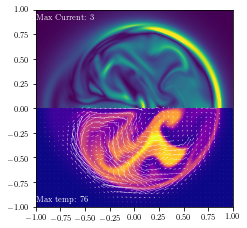

0017
Max current: 3
Max temperature $\times 10^{-6}$: 76


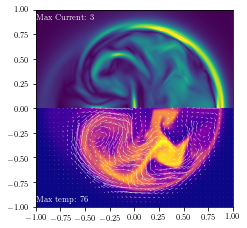

0018
Max current: 3
Max temperature $\times 10^{-6}$: 75


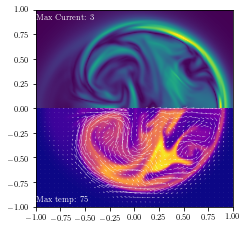

0019
Max current: 2
Max temperature $\times 10^{-6}$: 73


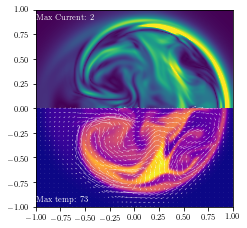

0020
Max current: 2
Max temperature $\times 10^{-6}$: 72


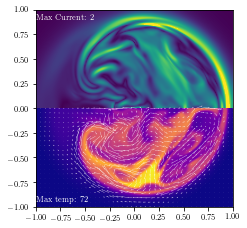

0021
Max current: 2
Max temperature $\times 10^{-6}$: 71


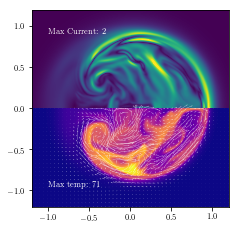

0022
Max current: 2
Max temperature $\times 10^{-6}$: 72


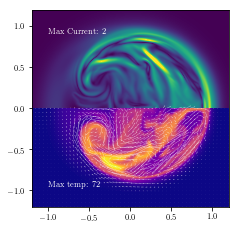

0023
Max current: 2
Max temperature $\times 10^{-6}$: 73


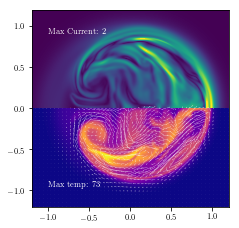

0024
Max current: 2
Max temperature $\times 10^{-6}$: 72


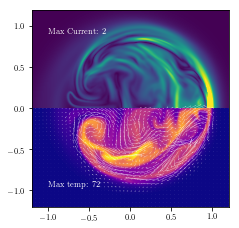

0025
Max current: 2
Max temperature $\times 10^{-6}$: 75


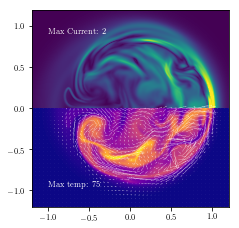

0026
Max current: 2
Max temperature $\times 10^{-6}$: 70


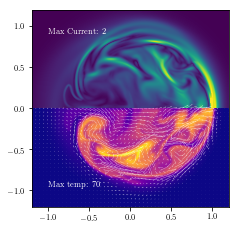

0027
Max current: 2
Max temperature $\times 10^{-6}$: 65


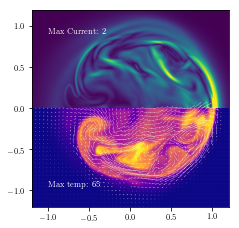

0028
Max current: 3
Max temperature $\times 10^{-6}$: 66


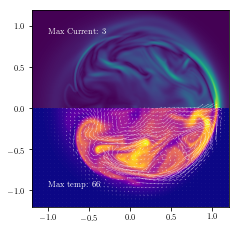

0029
Max current: 3
Max temperature $\times 10^{-6}$: 64


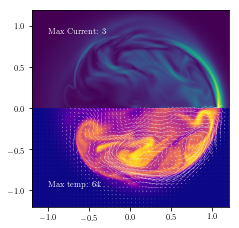

0030
Max current: 2
Max temperature $\times 10^{-6}$: 63


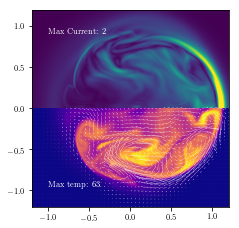

0031
Max current: 2
Max temperature $\times 10^{-6}$: 69


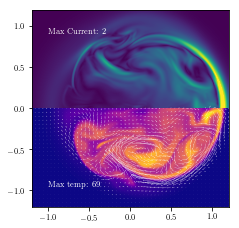

0032
Max current: 2
Max temperature $\times 10^{-6}$: 72


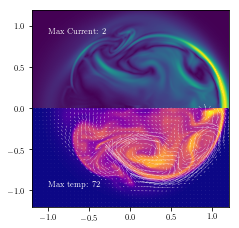

0033
Max current: 2
Max temperature $\times 10^{-6}$: 71


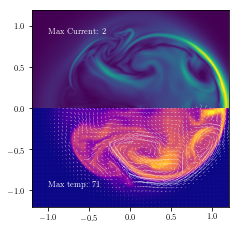

0034
Max current: 2
Max temperature $\times 10^{-6}$: 70


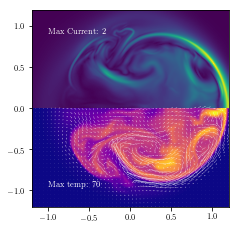

0035
Max current: 1
Max temperature $\times 10^{-6}$: 74


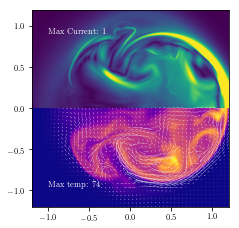

0036
Max current: 1
Max temperature $\times 10^{-6}$: 71


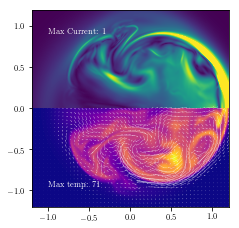

0037
Max current: 1
Max temperature $\times 10^{-6}$: 69


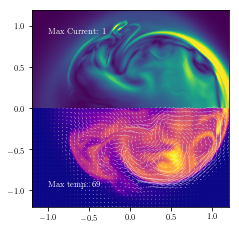

0038
Max current: 1
Max temperature $\times 10^{-6}$: 67


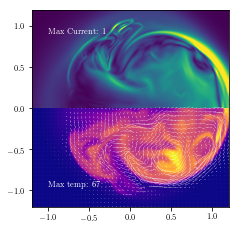

0039
Max current: 1
Max temperature $\times 10^{-6}$: 66


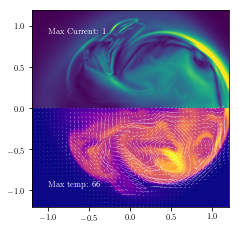

0040
Max current: 1
Max temperature $\times 10^{-6}$: 71


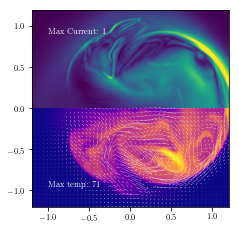

0041
Max current: 1
Max temperature $\times 10^{-6}$: 71


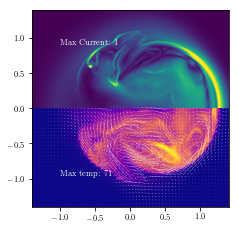

0042
Max current: 1
Max temperature $\times 10^{-6}$: 71


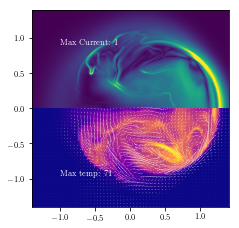

0043
Max current: 1
Max temperature $\times 10^{-6}$: 69


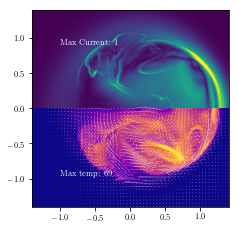

0044
Max current: 1
Max temperature $\times 10^{-6}$: 69


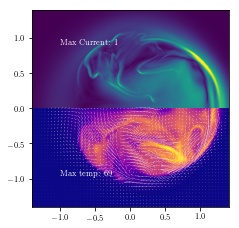

0045
Max current: 1
Max temperature $\times 10^{-6}$: 67


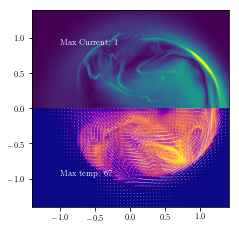

0046
Max current: 1
Max temperature $\times 10^{-6}$: 66


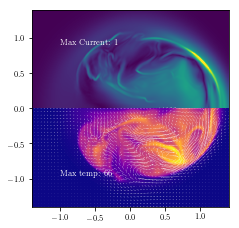

0047
Max current: 1
Max temperature $\times 10^{-6}$: 65


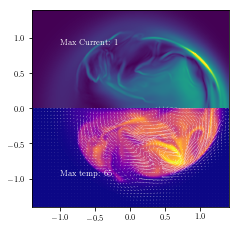

0048
Max current: 1
Max temperature $\times 10^{-6}$: 67


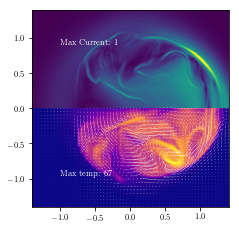

0049
Max current: 1
Max temperature $\times 10^{-6}$: 68


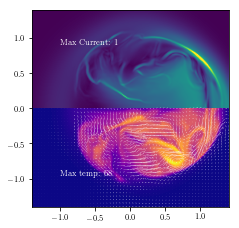

0050
Max current: 1
Max temperature $\times 10^{-6}$: 68


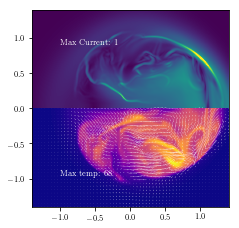

0051
Max current: 1
Max temperature $\times 10^{-6}$: 66


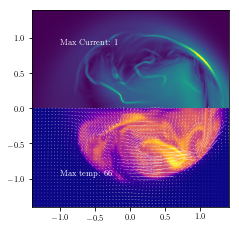

0052
Max current: 1
Max temperature $\times 10^{-6}$: 65


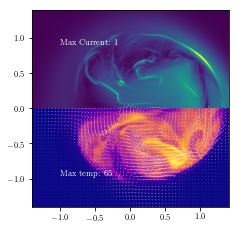

In [11]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"

xLimits = [(-1, 1) for i in range(21)]\
+ [(-1.2, 1.2) for i in range(21, 41)]\
+ [(-1.4, 1.4) for i in range(41, 56)]
yLimits = [(0, 1) for i in range(21)]\
+ [(0, 1.2) for i in range(21, 34)]\
+ [(0, 1.4) for i in range(34, 56)]
    
for i in range(0, 53):
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'switching_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                    xLimits=xLimits[i],yLimits=yLimits[i])

# Specific slices; both; t=13, 15, 20

0013
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


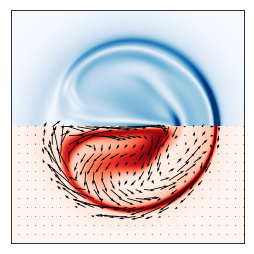

0015
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


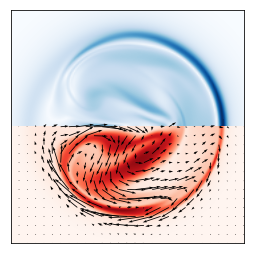

0020
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


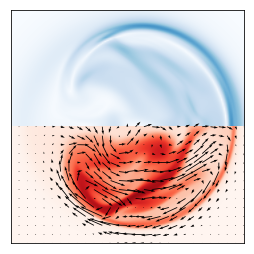

0013
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


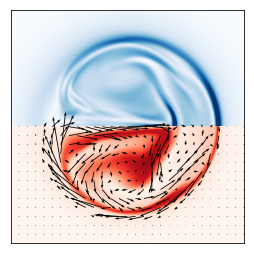

0015
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


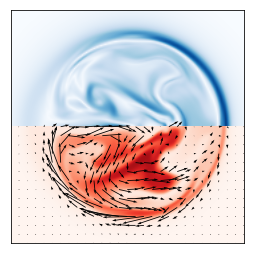

0020
Max current: 3.5
Max temperature $\times 10^{-6}$: 90.0


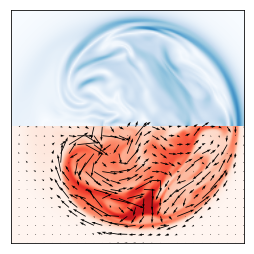

In [59]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"

for i in [13, 15, 20]:
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'final_isotropic_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                                      xLimits=(-1, 1),\
                                      yLimits=(0, 1),\
                                      print_maxes=False,\
                                     max_current=3.5,\
                                     max_temperature=90*1e6,\
                                     remove_axes=True)

folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"

for i in [13,15, 20]:
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'final_switching_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                                      xLimits=(-1, 1),\
                                      yLimits=(0, 1),\
                                      print_maxes=False,\
                                     max_current=3.5,\
                                     max_temperature=90*1e6,\
                                     remove_axes=True)

# Specific slices; iso; t=25, 30, 35

0025
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


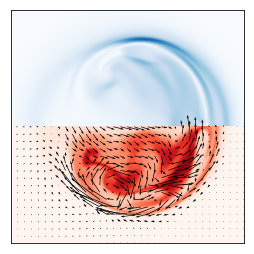

0030
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


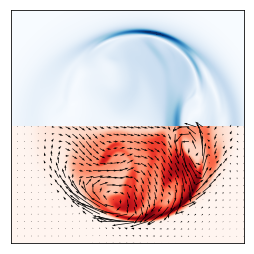

0035
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


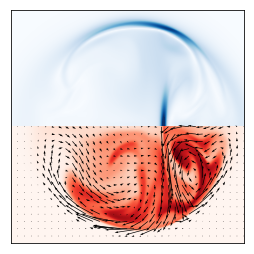

In [60]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-isotropic/Data/"

for i in [25, 30, 35]:
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'final_isotropic_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                                      xLimits=(-1.2, 1.2),\
                                      yLimits=(0, 1.2),\
                                      print_maxes=False,\
                                     max_current=3,
                                     max_temperature=85*1e6,\
                                     remove_axes=True)

0025
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


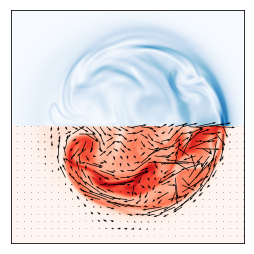

0030
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


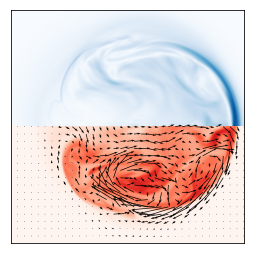

0035
Max current: 3
Max temperature $\times 10^{-6}$: 85.0


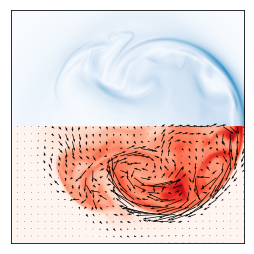

In [61]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"

for i in [25, 30, 35]:
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    outname = 'final_switching_current_density_' + timedump + '.pdf'
    print(timedump)
    plot_current_density_and_velocity(sdfFile, outname,\
                                      xLimits=(-1.2, 1.2),\
                                      yLimits=(0, 1.2),\
                                      print_maxes=False,\
                                     max_current=3,
                                     max_temperature=85*1e6,\
                                     remove_axes=True)

# Testing size of $s$

In [20]:
folder = "/nas/1101974q/archie-latest-organisation-sept-2018/kink-instabilities/initially-unstable/cadence-5-v1e-4r5e-4.5/v1e-4r5e-4.5-switching/Data/"

# timedump = '{0:04d}'.format(20)
# sdfFilename = folder + timedump + ".sdf"
# sdfFile = sdf.read(sdfFilename)
# dir(sdfFile)
# # sdf_var = getattr(sdfFile, "Fluid_Switching_Function")
# # print(np.min(sdf_var.data))

max_heating = 0.0

for i in range(0, 53):
    timedump = '{0:04d}'.format(i)
    sdfFilename = folder + timedump + ".sdf"
    sdfFile = sdf.read(sdfFilename)
    sdf_var = getattr(sdfFile, "Viscous_heating_total")
    var = sdf_var.data
    local_max = np.max(sdf_var.data)
    if local_max > max_heating:
        max_heating = local_max
    print(i, local_max)

0 0.0
1 8.19272563325e-09
2 1.62406395818e-08
3 2.47094260121e-08
4 3.52587924679e-08
5 5.16806869909e-08
6 8.7413262174e-08
7 1.92107717013e-07
8 4.84735359054e-07
9 1.98769233968e-06
10 5.00371300506e-06
11 8.8649426708e-06
12 1.410802481e-05
13 2.14049316572e-05
14 2.99618386556e-05
15 3.91920422253e-05
16 5.05243228042e-05
17 6.55875868148e-05
18 8.72562425412e-05
19 0.000112454277039
20 0.000137520755401
21 0.00016181857657
22 0.000187045354626
23 0.000212124668697
24 0.000239748021256
25 0.000268999935138
26 0.000298212197504
27 0.000327165466751
28 0.000355878009296
29 0.000383529834489
30 0.00040890018225
31 0.000432689718991
32 0.000455631290772
33 0.000478880603539
34 0.00050490533593
35 0.000532440080142
36 0.000560366579572
37 0.000587617565174
38 0.000616801382486
39 0.00064907164259
40 0.000684916575162
41 0.00072236324478
42 0.000760075282342
43 0.00079742549272
44 0.000835469847361
45 0.000872817048026
46 0.000907140831522
47 0.000937548410126
48 0.000964058917411
49 0.